In [14]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from util_data import *
from util_hmm_variational_gibbs import *
from util_plots import *
from scipy.stats import invwishart, dirichlet
from torch.distributions.dirichlet import Dirichlet
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [24]:
## Dataset parameters
num_series = 50
T = 50
K = 4
D = 2
dt = 10
Boundary = 30
noise_factor = 0.5

## Model Parameters
num_particles_rws = 30
mcmc_steps = 2
num_particles_smc = 30
NUM_HIDDEN = 128
NUM_LATENTS = K*K
NUM_OBS = T * K

NUM_EPOCHS = 80
LEARNING_RATE = 1e-3
CUDA = False

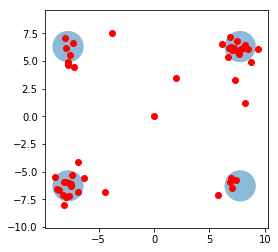

[[0.82256169 0.05875441 0.00117509 0.11750881]
 [0.14245014 0.56980057 0.28490028 0.002849  ]
 [0.05882353 0.05882353 0.82352941 0.05882353]
 [0.12468828 0.00249377 0.12468828 0.74812968]]


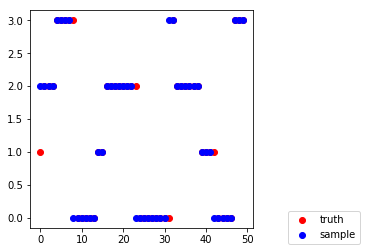

In [31]:
noise_cov = np.array([[1, 0], [0, 1]]) * noise_factor
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle

STATE, Disp, A_true, Zs_true = generate_seq(T, dt, Boundary, init_v, noise_cov)
## true global variables
cov_true = np.tile(noise_cov, (K, 1, 1))
dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
Pi_true = np.ones(K) * (1/K)

plot_clusters(Disp, mu_true, cov_true, K)
Zs_true = torch.from_numpy(Zs_true).float()
cov_ks = torch.from_numpy(cov_true).float()
mu_ks = torch.from_numpy(mu_true).float()
Pi = torch.from_numpy(Pi_true).float()
A_init = torch.from_numpy(A_true).float()
## piror of A
alpha_trans_0 = initial_trans_prior(K)
## Y
Y = torch.from_numpy(Disp).float()
print(A_true)

A_samples = A_init
Zs, log_weights, log_normalizer = smc_hmm(Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
Z_ret = resampling_smc(Zs, log_weights)
plot_smc_sample(Zs_true, Z_ret)

In [32]:
## return samples in order to compute the weights and 
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, init_smc):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden).view(K, K))
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [33]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [ ]:
KLs = []
EUBOs = []
log_p_conds = []
log_qs = []
ESSs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
    v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
    init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
    STATE, Disp, A_true, Zs_true = generate_seq(T, dt, Boundary, init_v, noise_cov)
    ## true global variables
    cov_true = np.tile(noise_cov, (K, 1, 1))
    dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
    mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
    Pi_true = np.ones(K) * (1/K)
    cov_ks = torch.from_numpy(cov_true).float()
    mu_ks = torch.from_numpy(mu_true).float()
    Pi = torch.from_numpy(Pi_true).float()
    A_init = initial_trans(alpha_trans_0, K)
#     A_init = torch.from_numpy(A_true).float()
    alpha_trans_0 = initial_trans_prior(K)
    Y = torch.from_numpy(Disp).float()
    

    enc, loss_infer, eubo, kl, ess, latents_dirs, Z_ret = rws2(enc, A_init, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles_rws, num_particles_smc, mcmc_steps)
#     kl_est = torch.mul(weights_rws, log_p_conds - log_qs).sum().detach().item()
    log_q = - loss_infer
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo)
    ESSs.append(ess)
    log_qs.append(log_q)
    optimizer.step()
#     A_samples = A_samples.detach()
    time_end = time.time()
    print('epoch : %d, eubo : %f, log_q : %f, KL : %f (%ds)' % (epoch, eubo, log_q, kl, time_end - time_start))

epoch : 0, eubo : -412.635071, log_q : 7.038049, KL : 12.875433 (45s)
epoch : 1, eubo : -600.581238, log_q : 7.148615, KL : 12.504327 (44s)
epoch : 2, eubo : -372.235443, log_q : 7.268705, KL : 11.915651 (44s)
epoch : 3, eubo : -417.763458, log_q : 7.139396, KL : 11.072739 (44s)
epoch : 4, eubo : -452.310791, log_q : 7.619434, KL : 11.175982 (44s)
epoch : 5, eubo : -482.829468, log_q : 6.819568, KL : 11.156222 (44s)
epoch : 6, eubo : -417.891937, log_q : 6.998171, KL : 11.698053 (44s)
epoch : 7, eubo : -329.229156, log_q : 7.961162, KL : 11.029461 (44s)
epoch : 8, eubo : -430.319427, log_q : 8.127460, KL : 10.808185 (44s)
epoch : 9, eubo : -529.090271, log_q : 7.772892, KL : 11.287006 (44s)
epoch : 10, eubo : -660.136047, log_q : 7.167252, KL : 12.110833 (44s)
epoch : 11, eubo : -438.850677, log_q : 8.051297, KL : 12.212613 (44s)
epoch : 12, eubo : -511.207733, log_q : 7.440315, KL : 10.584105 (44s)
epoch : 13, eubo : -507.281372, log_q : 7.621957, KL : 9.579479 (43s)
epoch : 14, eubo 

In [ ]:
learned_dicichlet_post = latents_dirs
true_dirichlet_post = alpha_trans_0 + pairwise(torch.from_numpy(Zs_true).float(), T).sum(0)
print('variational : ')
print(learned_dicichlet_post)
print('conjugate posterior :')
print(true_dirichlet_post)
plot_dirs(learned_dicichlet_post.data.numpy(), true_dirichlet_post.data.numpy(), vmax=12)

In [ ]:
plt.plot(np.array(ESSs) / num_particles_rws)

In [ ]:
learned_dicichlet_post.sum()

In [ ]:
true_dirichlet_post.sum()

In [ ]:
alpha_trans_0.sum()

In [9]:
np.random.randint(3,5)

4